In this notebook, we will try to enrich datas as much as possible

In [150]:
import os
import sys
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)
utils_dir = os.path.join(parent_dir, "src", "utils")
sys.path.append(utils_dir)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import xgboost as xgb

from process_data import process_data

In [151]:
X_train_path= os.path.join("..", "data","original_input", "X_train_Wwou3IE.csv")
X_train_preprocessed = pd.read_csv(X_train_path, delimiter=',')
X_test_path= os.path.join("..", "data","original_input", "X_test_GgyECq8.csv")
X_test_preprocessed = pd.read_csv(X_test_path, delimiter=',')
y_train_path= os.path.join("..", "data","original_input", "y_train_jJtXgMX.csv")
y_train_preprocessed = pd.read_csv(y_train_path, delimiter=',')

delivery_start = X_test_preprocessed["DELIVERY_START"]

In [152]:
delivery_start

0       2023-04-02 00:00:00+02:00
1       2023-04-02 01:00:00+02:00
2       2023-04-02 02:00:00+02:00
3       2023-04-02 03:00:00+02:00
4       2023-04-02 04:00:00+02:00
                  ...            
4937    2023-10-24 19:00:00+02:00
4938    2023-10-24 20:00:00+02:00
4939    2023-10-24 21:00:00+02:00
4940    2023-10-24 22:00:00+02:00
4941    2023-10-24 23:00:00+02:00
Name: DELIVERY_START, Length: 4942, dtype: object

In [153]:
X_train_preprocessed['DELIVERY_START'] = pd.to_datetime(X_train_preprocessed['DELIVERY_START'], utc = True)
X_train_preprocessed.set_index('DELIVERY_START', inplace=True)

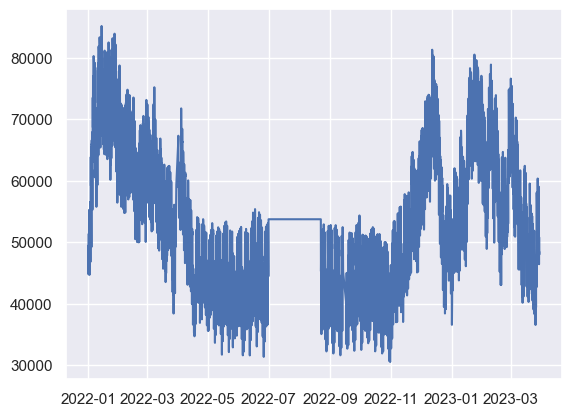

In [154]:
means = X_train_preprocessed.mean()

# Fill missing values with the mean of each column
df_filled = X_train_preprocessed.fillna(means)
plt.plot(df_filled.index ,df_filled["load_forecast"])

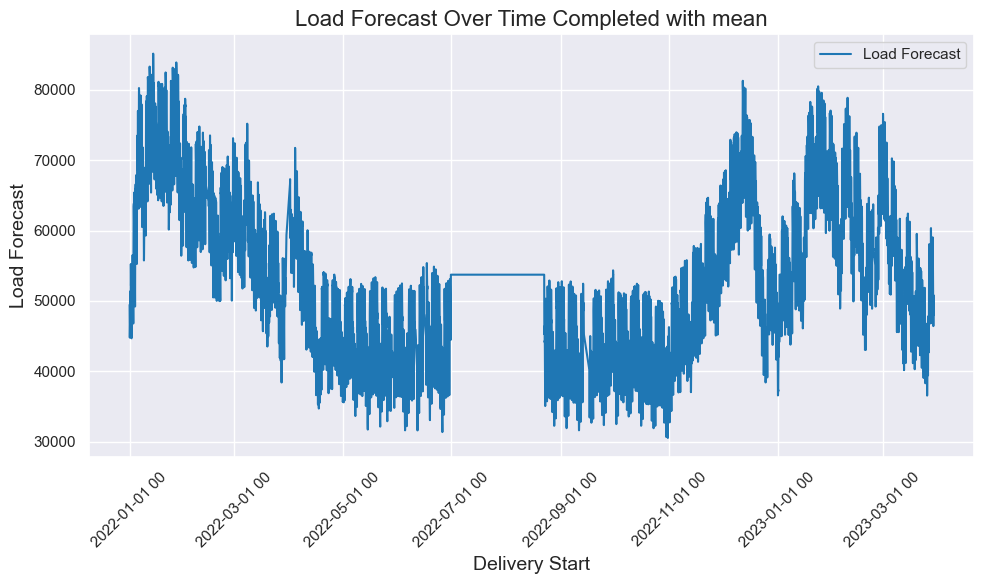

In [155]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

# Assuming df_filled.index is already a DatetimeIndex
# Setting seaborn style for better aesthetics
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True)

plt.figure(figsize=(10, 6))

# Plot data
plt.plot(df_filled.index, df_filled["load_forecast"], label='Load Forecast', color='tab:blue', linestyle='-')

# Custom formatter function to avoid displaying zero for hours
def custom_date_formatter(x, pos):
    date = mdates.num2date(x)
    if date.hour == 0:
        return date.strftime('%Y-%m-%d')
    else:
        return date.strftime('%Y-%m-%d %H')

# Apply the custom formatter
plt.gca().xaxis.set_major_formatter(FuncFormatter(custom_date_formatter))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.title('Load Forecast Over Time Completed with mean', fontsize=16)
plt.xlabel('Delivery Start', fontsize=14)
plt.ylabel('Load Forecast', fontsize=14)

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [156]:
split_index = pd.to_datetime('2022-06-30 23:00:00+00:00')

# Split the DataFrame into two parts
# df1 will contain rows up to and including the split_index
df1 = X_train_preprocessed.loc[:split_index]

# df2 will contain rows after the split_index
df2 = X_train_preprocessed.loc[split_index + pd.Timedelta(seconds=1):]
X_train_preprocessed_before = X_train_preprocessed.copy(deep=True)
df1_clean = df1.dropna(subset=['load_forecast'])
df2_clean = df2.dropna(subset=['load_forecast'])
n_to_replace = len(X_train_preprocessed) - len(df1_clean) - len(df2_clean)
len(df1_clean), n_to_replace
start_index_for_replacement_values = len(df1_clean) - n_to_replace
end_index_for_replacement_values = len(df1_clean)

# Calculate start and end indices for the missing values
start_index_for_missing_values = len(df1_clean)
end_index_for_missing_values = len(df1_clean) + n_to_replace

# Select the replacement values
replacement_values = X_train_preprocessed.iloc[start_index_for_replacement_values:end_index_for_replacement_values]['load_forecast'].values

# Replace the missing values
X_train_preprocessed.iloc[start_index_for_missing_values:end_index_for_missing_values, X_train_preprocessed.columns.get_loc('load_forecast')] = replacement_values
X_train_preprocessed.to_csv("../data/original_input/X_train_filled.csv", index = True)

In [157]:
temperature_p_mois = {
    1: 4.9,
    2: 5.5,
    3: 8.3,
    4: 11.0,
    5: 14.5,
    6: 17.9,
    7: 20.1,
    8: 20.0,
    9: 16.7,
    10: 13.0,
    11: 8.4,
    12: 5.5
}

X_train_preprocessed["DELIVERY_START"] = X_train_preprocessed.index 
X_train_preprocessed['month'] = X_train_preprocessed["DELIVERY_START"].dt.month
X_train_preprocessed['cold_rate'] = X_train_preprocessed['month'].map(temperature_p_mois)
X_train_preprocessed.drop('month', axis=1, inplace=True)

X_test_preprocessed['DELIVERY_START'] = pd.to_datetime(X_test_preprocessed['DELIVERY_START'], utc = True)

X_test_preprocessed['month'] = X_test_preprocessed['DELIVERY_START'].dt.month
X_test_preprocessed['cold_rate'] = X_test_preprocessed['month'].map(temperature_p_mois)
X_test_preprocessed.drop('month', axis=1, inplace=True)

In [158]:
consommation_heure = {
    0: 51957,
    1: 47708,
    2: 46755,
    3: 44511,
    4: 42790,
    5: 42645,
    6: 44726,
    7: 48151,
    8: 51093,
    9: 53186,
    10: 54388,
    11: 54896,
    12: 56170,
    13: 56751,
    14: 54335,
    15: 52495,
    16: 51169,
    17: 50495,
    18: 51942,
    19: 54763,
    20: 54447,
    21: 51790,
    22: 50042,
    23: 52903
}

X_train_preprocessed['DELIVERY_START'] = pd.to_datetime(X_train_preprocessed['DELIVERY_START'], utc = True)

X_train_preprocessed['month'] = X_train_preprocessed['DELIVERY_START'].dt.hour
X_train_preprocessed['av_consuption_hour'] = X_train_preprocessed['month'].map(consommation_heure)
X_train_preprocessed.drop('month', axis=1, inplace=True)

X_train_preprocessed['DELIVERY_START'] = pd.to_datetime(X_train_preprocessed['DELIVERY_START'], utc = True)

X_test_preprocessed['month'] = X_test_preprocessed['DELIVERY_START'].dt.hour
X_test_preprocessed['av_consuption_hour'] = X_test_preprocessed['month'].map(consommation_heure)
X_test_preprocessed.drop('month', axis=1, inplace=True)

In [159]:
X_train_preprocessed.head()

,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price,DELIVERY_START,cold_rate,av_consuption_hour
DELIVERY_START,,,,,,,,,,,,
2022-01-01 01:00:00+00:00,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.0,NaN,2022-01-01 01:00:00+00:00,4.9,47708
2022-01-01 02:00:00+00:00,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.0,NaN,2022-01-01 02:00:00+00:00,4.9,46755
2022-01-01 03:00:00+00:00,45158.0,3386.0,11487.0,44118.0,3288.0,0.0,44.291112,0.0,NaN,2022-01-01 03:00:00+00:00,4.9,44511
2022-01-01 04:00:00+00:00,44779.0,3386.0,11487.0,44118.0,3447.0,0.0,36.127588,0.0,NaN,2022-01-01 04:00:00+00:00,4.9,42790
2022-01-01 05:00:00+00:00,45284.0,3386.0,11487.0,44118.0,3679.0,0.0,30.983023,0.0,NaN,2022-01-01 05:00:00+00:00,4.9,42645


In [160]:
y_train_preprocessed.head()

,DELIVERY_START,spot_id_delta
0,2022-01-01 02:00:00+01:00,-36.874770
1,2022-01-01 03:00:00+01:00,-12.643588
2,2022-01-01 04:00:00+01:00,-1.950193
3,2022-01-01 05:00:00+01:00,1.938272
4,2022-01-01 06:00:00+01:00,0.199907


In [161]:
def create_time_features(df) :
    df.set_index("DELIVERY_START")
    if not isinstance(df.index, pd.DatetimeIndex):
        # If not, then set 'DELIVERY_START' as the index and convert it to datetime
        df = df.set_index("DELIVERY_START")
        df.index = pd.to_datetime(df.index, utc=True)
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofyear"] = df.index.dayofyear
    return df

In [162]:
X_train_preprocessed = create_time_features(X_train_preprocessed)
X_test_preprocessed = create_time_features(X_test_preprocessed)

In [163]:
X_train_preprocessed

,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price,DELIVERY_START,cold_rate,av_consuption_hour,hour,dayofweek,quarter,month,year,dayofyear
DELIVERY_START,,,,,,,,,,,,,,,,,,
2022-01-01 01:00:00+00:00,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.000000,NaN,2022-01-01 01:00:00+00:00,4.9,47708,1,5,1,1,2022,1
2022-01-01 02:00:00+00:00,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.000000,NaN,2022-01-01 02:00:00+00:00,4.9,46755,2,5,1,1,2022,1
2022-01-01 03:00:00+00:00,45158.0,3386.0,11487.0,44118.0,3288.0,0.0,44.291112,0.000000,NaN,2022-01-01 03:00:00+00:00,4.9,44511,3,5,1,1,2022,1
2022-01-01 04:00:00+00:00,44779.0,3386.0,11487.0,44118.0,3447.0,0.0,36.127588,0.000000,NaN,2022-01-01 04:00:00+00:00,4.9,42790,4,5,1,1,2022,1
2022-01-01 05:00:00+00:00,45284.0,3386.0,11487.0,44118.0,3679.0,0.0,30.983023,0.000000,NaN,2022-01-01 05:00:00+00:00,4.9,42645,5,5,1,1,2022,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-29 17:00:00+00:00,50814.0,3386.0,11952.0,38320.0,7552.0,651.0,247.408490,7.821622,108.11,2023-03-29 17:00:00+00:00,8.3,50495,17,2,1,3,2023,88
2023-03-29 18:00:00+00:00,50628.0,3386.0,11952.0,38320.0,8338.0,109.0,155.795012,2.534054,125.66,2023-03-29 18:00:00+00:00,8.3,51942,18,2,1,3,2023,88
2023-03-29 19:00:00+00:00,48201.0,3386.0,11952.0,38320.0,9115.0,0.0,126.884684,0.000000,138.01,2023-03-29 19:00:00+00:00,8.3,54763,19,2,1,3,2023,88


In [164]:
y_train_preprocessed.set_index("DELIVERY_START", inplace=True)
if not isinstance(y_train_preprocessed.index, pd.DatetimeIndex):
    y_train_preprocessed.index = pd.to_datetime(y_train_preprocessed.index, utc=True)
print(y_train_preprocessed.shape, X_train_preprocessed.shape)
print(y_train_preprocessed.head())

(10605, 1) (10605, 18)
                           spot_id_delta
DELIVERY_START                          
2022-01-01 01:00:00+00:00     -36.874770
2022-01-01 02:00:00+00:00     -12.643588
2022-01-01 03:00:00+00:00      -1.950193
2022-01-01 04:00:00+00:00       1.938272
2022-01-01 05:00:00+00:00       0.199907


Text(0.5, 1.0, 'spot_id_delta per hour')

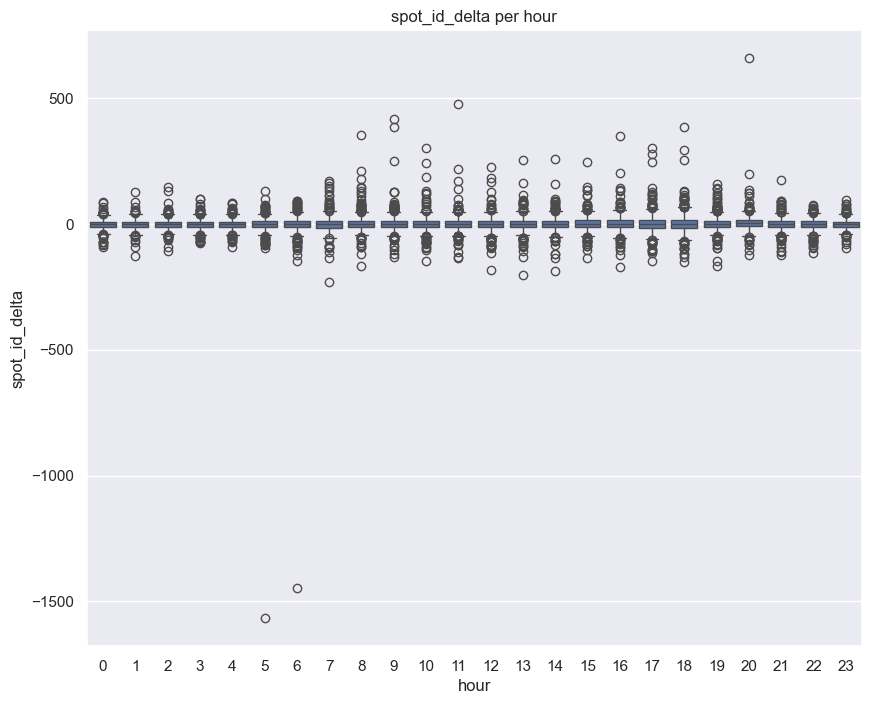

In [165]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.boxplot(data=y_train_preprocessed.join(X_train_preprocessed), x = "hour", y = "spot_id_delta")
ax.set_title("spot_id_delta per hour")

Text(0.5, 1.0, 'spot_id_delta per hour')

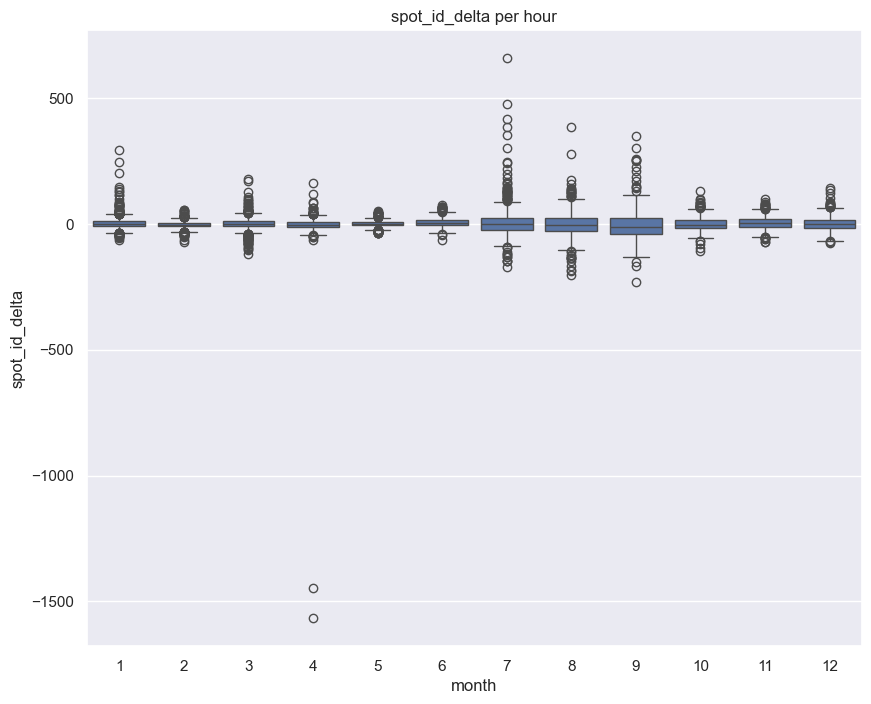

In [166]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.boxplot(data=y_train_preprocessed.join(X_train_preprocessed), x = "month", y = "spot_id_delta")
ax.set_title("spot_id_delta per hour")

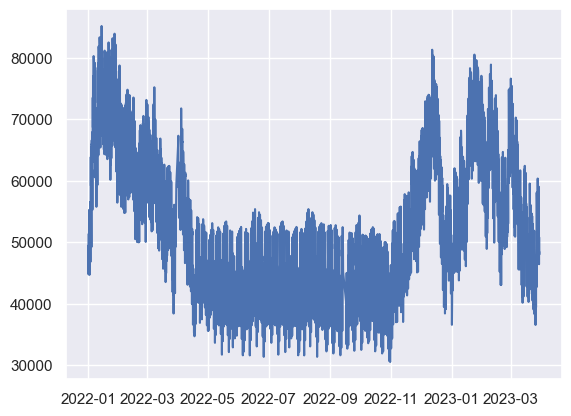

In [167]:
plt.plot(X_train_preprocessed.index ,X_train_preprocessed["load_forecast"])


In [168]:
missing_values = X_train_preprocessed[X_train_preprocessed['load_forecast'].isnull()]
missing_values

,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price,DELIVERY_START,cold_rate,av_consuption_hour,hour,dayofweek,quarter,month,year,dayofyear
DELIVERY_START,,,,,,,,,,,,,,,,,,
2023-01-01 23:00:00+00:00,NaN,3386.0,11945.0,39671.0,10148.0,0.0,102.209272,0.000000,NaN,2023-01-01 23:00:00+00:00,4.9,52903,23,6,1,1,2023,1
2023-01-02 00:00:00+00:00,NaN,3386.0,11945.0,39671.0,9380.0,0.0,159.580701,0.000000,NaN,2023-01-02 00:00:00+00:00,4.9,51957,0,0,1,1,2023,2
2023-01-02 01:00:00+00:00,NaN,3386.0,11945.0,39676.0,8505.0,0.0,325.478195,0.000000,NaN,2023-01-02 01:00:00+00:00,4.9,47708,1,0,1,1,2023,2
2023-01-02 02:00:00+00:00,NaN,3386.0,11945.0,39881.0,7756.0,0.0,497.564398,0.000000,NaN,2023-01-02 02:00:00+00:00,4.9,46755,2,0,1,1,2023,2
2023-01-02 03:00:00+00:00,NaN,3386.0,11945.0,39881.0,7277.0,0.0,576.413571,0.000000,NaN,2023-01-02 03:00:00+00:00,4.9,44511,3,0,1,1,2023,2
2023-01-02 04:00:00+00:00,NaN,3386.0,11945.0,40796.0,6806.0,0.0,695.196819,0.000000,NaN,2023-01-02 04:00:00+00:00,4.9,42790,4,0,1,1,2023,2
2023-01-02 05:00:00+00:00,NaN,3386.0,11945.0,42411.0,6411.0,0.0,805.064573,0.000000,NaN,2023-01-02 05:00:00+00:00,4.9,42645,5,0,1,1,2023,2
2023-01-02 06:00:00+00:00,NaN,3386.0,11945.0,43291.0,6240.0,0.0,788.814509,0.000000,NaN,2023-01-02 06:00:00+00:00,4.9,44726,6,0,1,1,2023,2
2023-01-02 07:00:00+00:00,NaN,3386.0,11945.0,43315.0,6278.0,136.0,641.525136,1.424574,NaN,2023-01-02 07:00:00+00:00,4.9,48151,7,0,1,1,2023,2


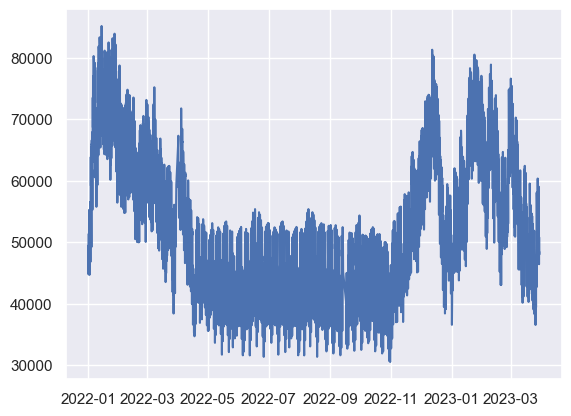

In [169]:
plt.plot(X_train_preprocessed.index ,X_train_preprocessed["load_forecast"])


In [170]:
X_train_preprocessed.shape, X_train_preprocessed_before.shape, 

((10605, 18), (10605, 9))

In [171]:
X_train_preprocessed.to_csv("../data/original_input/X_train_filled.csv", index = True)

In [172]:
X_train = process_data(X_train_preprocessed.copy(deep=True), "predicted_spot_price", None, "standard")
X_test = process_data(X_test_preprocessed.copy(deep=True), "predicted_spot_price", None, "standard")
y_train = process_data(y_train_preprocessed.copy(deep=True), None, None, None)

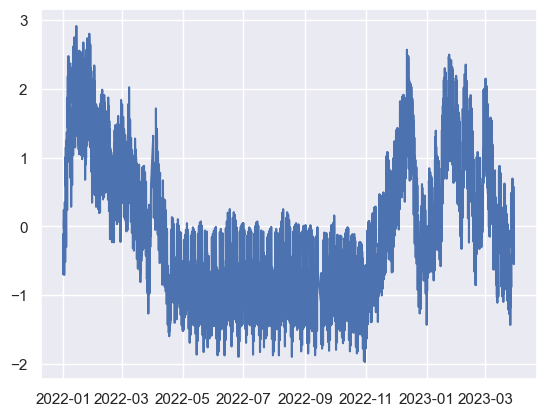

In [173]:
plt.plot(X_train.index ,X_train["load_forecast"])

In [174]:
X_train.head()

,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,cold_rate,av_consuption_hour,hour,dayofweek,quarter,month,year,dayofyear
DELIVERY_START,,,,,,,,,,,,,,,,
2022-01-01 01:00:00+00:00,-0.279534,1.143744,0.049156,1.145111,-0.441788,-0.709854,-0.349637,-0.580887,-1.112973,-0.775054,-1.519140,1.002602,-1.045267,-1.287117,-0.494838,-1.40631
2022-01-01 02:00:00+00:00,-0.541320,1.143744,0.049156,1.145111,-0.409506,-0.709854,-0.482002,-0.580887,-1.112973,-1.010691,-1.374581,1.002602,-1.045267,-1.287117,-0.494838,-1.40631
2022-01-01 03:00:00+00:00,-0.662288,1.143744,0.049156,1.145111,-0.366164,-0.709854,-0.614471,-0.580887,-1.112973,-1.565537,-1.230023,1.002602,-1.045267,-1.287117,-0.494838,-1.40631
2022-01-01 04:00:00+00:00,-0.696174,1.143744,0.049156,1.145111,-0.318637,-0.709854,-0.676317,-0.580887,-1.112973,-1.991068,-1.085464,1.002602,-1.045267,-1.287117,-0.494838,-1.40631
2022-01-01 05:00:00+00:00,-0.651023,1.143744,0.049156,1.145111,-0.249289,-0.709854,-0.715292,-0.580887,-1.112973,-2.026920,-0.940906,1.002602,-1.045267,-1.287117,-0.494838,-1.40631


In [175]:
y_train

,spot_id_delta
DELIVERY_START,
2022-01-01 01:00:00+00:00,-36.874770
2022-01-01 02:00:00+00:00,-12.643588
2022-01-01 03:00:00+00:00,-1.950193
2022-01-01 04:00:00+00:00,1.938272
2022-01-01 05:00:00+00:00,0.199907
...,...
2023-03-29 17:00:00+00:00,6.029303
2023-03-29 18:00:00+00:00,13.576177
2023-03-29 19:00:00+00:00,17.478945


In [176]:
X_test.index = delivery_start

In [177]:
X_train.to_csv("../data/enriched_input/X_train.csv", index = True)
X_test.to_csv("../data/enriched_input/X_test.csv", index = True)
y_train.to_csv("../data/enriched_input/y_train.csv", index = True)